# Perform single-cell quality control

In this notebook, we perform single-cell quality control using coSMicQC. e filter the single cells by identifying outliers with z-scores, and use either combinations of features or one feature for each condition. We use features from the AreaShape and Intensity modules to assess the quality of the segmented single-cells:

### Assessing poor nuclei segmentation

Due to high confluence, sometimes nuclei overlap on top of each other, creating highly intense clusters within the Hoechst channel. To identify these nuclei, we use:

- **Nuclei Area:** This metric quantifies the number of pixels in a nucleus segmentation. 
We detect nuclei that are abnormally large, which likely indicates poor nucleus segmentation where overlapping nuclei are merged into one segmentation. 
- **Nuclei Intensity:** This metric quantifies the total intensity of all pixels in a nucleus segmentation. 
In combination with abnormally large nuclei, we detect nuclei that are also highly intense, likely indicating that this a group of overlapped nuclei.

### Assessing poor cell segmentation

Also due to high confluence, images with large, intense clusters of cells leads to errors in the segmentation algorithm that causes cells around the cluster to segmented incorrectly. 
When this happens, a cell is segmented around the same segmentation as the nucleus, giving it the same area which is very small for a normal cardiac fibroblast cell. To detect poorly segmented cells, we use:

- **Cells area in conjunction with nuclei area:** The Cells Area metric quantifies the number of pixels in a cell segmentation.
We detect cells that are abnormally small using nuclei area as the threshold to try and avoid removing too many properly segmented cells. 
We find cells that are with 2 standard deviations above the nuclei mean are more likely  to be poor cell segmentation due to high confluence clusters.

In [1]:
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from cosmicqc import find_outliers

/home/jenna/mambaforge/envs/python_analysis_cfret/lib/python3.9/site-packages/paramiko/pkey.py:100: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
/home/jenna/mambaforge/envs/python_analysis_cfret/lib/python3.9/site-packages/paramiko/transport.py:259: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


## Set paths and variables

In [2]:
# Directory with data
data_dir = pathlib.Path("./data/converted_profiles/")

# Directory to save cleaned data
cleaned_dir = pathlib.Path("./data/cleaned_profiles/")
cleaned_dir.mkdir(exist_ok=True)

# Directory to save qc figures
qc_fig_dir = pathlib.Path("./qc_figures")
qc_fig_dir.mkdir(exist_ok=True)

# Create an empty dictionary to store data frames for each plate
all_qc_data_frames = {}

# metadata columns to include in output data frame
metadata_columns = [
    "Image_Metadata_Plate",
    "Image_Metadata_Well",
    "Image_Metadata_Site",
    "Metadata_Nuclei_Location_Center_X",
    "Metadata_Nuclei_Location_Center_Y",
]

## Load in plate to perform QC on

In [3]:
# Set plate as variable to load in
plate = "localhost220513100001_KK22-05-198_FactinAdjusted"

# Load in converted plate data
plate_df = pd.read_parquet(f"{data_dir}/{plate}_converted.parquet")

# Add plate values if plate_4 is loaded in as it is absent due to error
if plate == 'localhost231120090001':
    plate_df['Image_Metadata_Plate'] = 'localhost231120090001'

print(plate_df.shape)
plate_df.head()

(11791, 2016)


,Metadata_Nuclei_Location_Center_X,Metadata_Nuclei_Location_Center_Y,Metadata_Cells_Location_Center_X,Metadata_Cells_Location_Center_Y,Metadata_Image_Count_Cells,Metadata_ImageNumber,Image_Metadata_Plate,Image_Metadata_Site,Image_Metadata_Well,Metadata_Cells_Number_Object_Number,...,Nuclei_Texture_Variance_Hoechst_3_02_256,Nuclei_Texture_Variance_Hoechst_3_03_256,Nuclei_Texture_Variance_Mitochondria_3_00_256,Nuclei_Texture_Variance_Mitochondria_3_01_256,Nuclei_Texture_Variance_Mitochondria_3_02_256,Nuclei_Texture_Variance_Mitochondria_3_03_256,Nuclei_Texture_Variance_PM_3_00_256,Nuclei_Texture_Variance_PM_3_01_256,Nuclei_Texture_Variance_PM_3_02_256,Nuclei_Texture_Variance_PM_3_03_256
0,198.097124,100.418340,233.908154,97.232759,34,1,localhost220513100001_KK22-05-198_FactinAdjusted,f00,A09,1,...,1.772868,1.781751,5.503105,4.731271,4.773240,4.969606,3.898170,3.514182,3.543228,3.644654
1,419.488971,115.273897,423.043530,103.325259,34,1,localhost220513100001_KK22-05-198_FactinAdjusted,f00,A09,2,...,2.435366,2.437117,0.274758,0.288000,0.279136,0.261363,0.452281,0.439173,0.448468,0.432924
2,98.052028,129.268078,98.678869,121.191226,34,1,localhost220513100001_KK22-05-198_FactinAdjusted,f00,A09,3,...,18.135150,17.438132,2.412237,2.248700,2.497164,2.562586,2.083484,1.961471,2.066848,2.137694
3,155.131181,149.960852,163.177967,171.310538,34,1,localhost220513100001_KK22-05-198_FactinAdjusted,f00,A09,4,...,6.588626,6.319666,12.619880,13.318648,16.168438,12.400382,6.643136,6.964105,7.965709,6.458424
4,513.226930,205.538015,514.276544,204.654352,34,1,localhost220513100001_KK22-05-198_FactinAdjusted,f00,A09,5,...,1.437521,1.407330,0.620726,0.597457,0.607785,0.612614,0.683401,0.694862,0.731775,0.694730


## Oversegmented nuclei with very high intensity (clusters)

In [4]:
# Set outlier threshold that maximizes removing most technical outliers and minimizes good cells
outlier_threshold = 2

# find large nuclei and high intensity
feature_thresholds = {
    "Nuclei_AreaShape_Area": outlier_threshold,
    "Nuclei_Intensity_IntegratedIntensity_Hoechst": outlier_threshold,
}

large_nuclei_high_int_outliers = find_outliers(
    df=plate_df,
    metadata_columns=metadata_columns,
    feature_thresholds=feature_thresholds
)

print(large_nuclei_high_int_outliers.shape)
large_nuclei_high_int_outliers.head()

Number of outliers: 186
Outliers Range:
Nuclei_AreaShape_Area Min: 2818.0
Nuclei_AreaShape_Area Max: 7790.0
Nuclei_Intensity_IntegratedIntensity_Hoechst Min: 145.95803795196116
Nuclei_Intensity_IntegratedIntensity_Hoechst Max: 936.3163515180349
(186, 7)


,Nuclei_AreaShape_Area,Nuclei_Intensity_IntegratedIntensity_Hoechst,Image_Metadata_Plate,Image_Metadata_Well,Image_Metadata_Site,Metadata_Nuclei_Location_Center_X,Metadata_Nuclei_Location_Center_Y
539,3617.0,154.366904,localhost220513100001_KK22-05-198_FactinAdjusted,A12,f06,828.715787,184.125242
551,3095.0,153.008683,localhost220513100001_KK22-05-198_FactinAdjusted,A12,f06,427.046850,723.114701
832,3441.0,169.980133,localhost220513100001_KK22-05-198_FactinAdjusted,B09,f12,977.657948,607.992153
1494,2996.0,173.432044,localhost220513100001_KK22-05-198_FactinAdjusted,B12,f04,62.478638,656.252670
1496,3940.0,152.453041,localhost220513100001_KK22-05-198_FactinAdjusted,B12,f04,413.708376,769.051777


### Scatterplot of area to integrated intensity

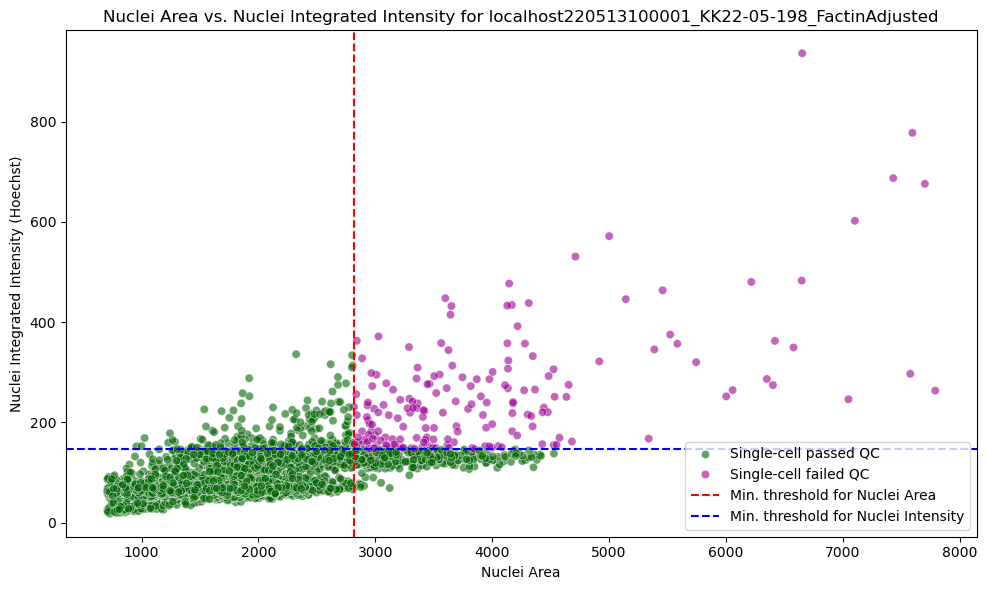

In [5]:
# Set the default value to 'inlier'
plate_df['Outlier_Status'] = 'Single-cell passed QC'

# Update the 'Outlier_Status' column based on the outliers DataFrame using index
plate_df.loc[plate_df.index.isin(large_nuclei_high_int_outliers.index), 'Outlier_Status'] = 'Single-cell failed QC'

# Create scatter plot
plt.figure(figsize=(10, 6))
plot = sns.scatterplot(
    data=plate_df,
    x="Nuclei_AreaShape_Area",
    y="Nuclei_Intensity_IntegratedIntensity_Hoechst",
    hue="Outlier_Status",
    palette={'Single-cell passed QC': '#006400', 'Single-cell failed QC': '#990090'},  # Specify colors
    alpha=0.6
)

# Add threshold lines
plt.axvline(
    x=large_nuclei_high_int_outliers['Nuclei_AreaShape_Area'].min(),
    color="r",
    linestyle="--",
    label='Min. threshold for Nuclei Area'
)
plt.axhline(
    y=large_nuclei_high_int_outliers['Nuclei_Intensity_IntegratedIntensity_Hoechst'].min(),
    color="b",
    linestyle="--",
    label='Min. threshold for Nuclei Intensity'
)

plt.title(f"Nuclei Area vs. Nuclei Integrated Intensity for {plate}")
plt.xlabel("Nuclei Area")
plt.ylabel("Nuclei Integrated Intensity (Hoechst)")
plt.tight_layout()

# Show the legend
plt.legend(loc='lower right', bbox_to_anchor=(1.0, 0), prop={'size': 10})

# Save figure
plt.savefig(pathlib.Path(f"{qc_fig_dir}/{plate}_nuclei_outliers.png"), dpi=500)

plt.show()


## Mis-segmented cells due to high confluence (segmentation for cells around the nuclei)

In [6]:
# find large nuclei and high intensity
if plate == "localhost230405150001": # for plate 3
    # Set threshold more strict as it is not enough to remove most outliers
    feature_thresholds = {
        "Cells_AreaShape_Area": -0.9,
    }
else:
    # This threshold can work for plate 4 and the pilot plates which removes most outliers
    feature_thresholds = {
        "Cells_AreaShape_Area": -1,
    }


small_cells_outliers = find_outliers(
    df=plate_df,
    metadata_columns=metadata_columns,
    feature_thresholds=feature_thresholds
)

print(small_cells_outliers.shape)
small_cells_outliers.sort_values(by="Cells_AreaShape_Area", ascending=False).head()

Number of outliers: 1800
Outliers Range:
Cells_AreaShape_Area Min: 762.0
Cells_AreaShape_Area Max: 3053.0
(1800, 6)


,Cells_AreaShape_Area,Image_Metadata_Plate,Image_Metadata_Well,Image_Metadata_Site,Metadata_Nuclei_Location_Center_X,Metadata_Nuclei_Location_Center_Y
7297,3053.0,localhost220513100001_KK22-05-198_FactinAdjusted,F10,f05,377.847495,110.644154
9646,3051.0,localhost220513100001_KK22-05-198_FactinAdjusted,G11,f06,354.890282,724.508621
8754,3048.0,localhost220513100001_KK22-05-198_FactinAdjusted,G10,f02,704.342515,463.252695
8949,3044.0,localhost220513100001_KK22-05-198_FactinAdjusted,G10,f05,387.193583,655.165775
4922,3042.0,localhost220513100001_KK22-05-198_FactinAdjusted,E09,f02,993.650547,399.264599


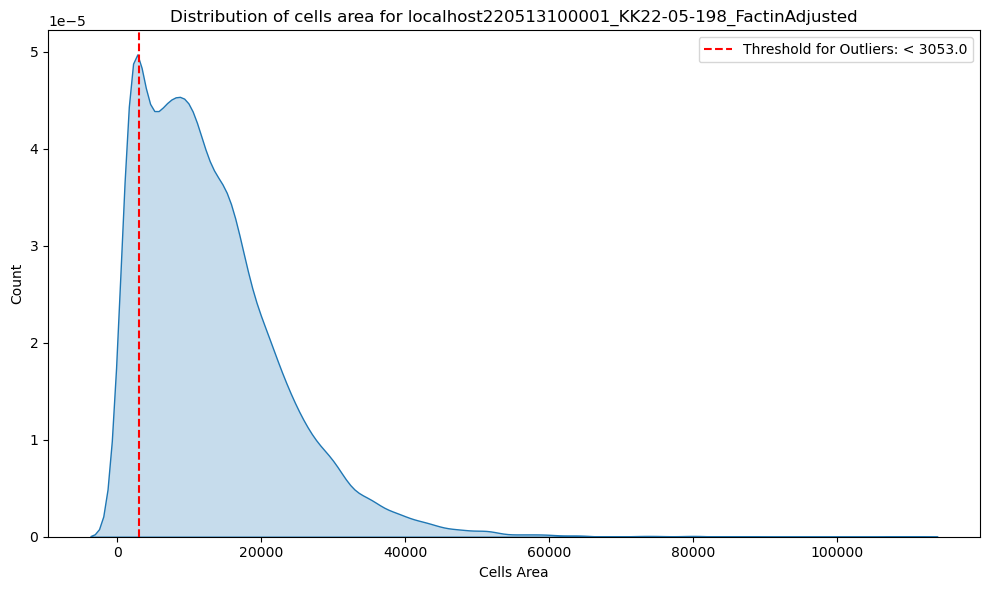

In [7]:
# Create a density plot
plt.figure(figsize=(10, 6))
sns.kdeplot(x='Cells_AreaShape_Area', data=plate_df, fill=True)

# Add threshold line
plt.axvline(
    x=small_cells_outliers["Cells_AreaShape_Area"].max(),
    color="r",
    linestyle="--",
    label=f'Threshold for Outliers: < {small_cells_outliers["Cells_AreaShape_Area"].max()}',
)

# Set labels and title
plt.ylabel('Count')
plt.xlabel('Cells Area')
plt.title(f'Distribution of cells area for {plate}')
plt.legend()
plt.tight_layout()

# save figure
plt.savefig(pathlib.Path(f"{qc_fig_dir}/{plate}_cells_outliers.png"), dpi=500)

# Show the plot
plt.show()

## Remove all outliers and save cleaned data frame

In [8]:
# Assuming nuclei_outliers_df and cells_outliers_df have the same index
outlier_indices = pd.concat([large_nuclei_high_int_outliers, small_cells_outliers]).index

# Remove rows with outlier indices from plate_4_df
plate_df_cleaned = plate_df.drop(outlier_indices)

# Save cleaned data for this plate
plate_name = plate_df['Image_Metadata_Plate'].iloc[0]
plate_df_cleaned.to_parquet(f"{cleaned_dir}/{plate_name}_cleaned.parquet")

# Verify the result
print(plate_df_cleaned.shape)
plate_df_cleaned.head()

(9806, 2017)


,Metadata_Nuclei_Location_Center_X,Metadata_Nuclei_Location_Center_Y,Metadata_Cells_Location_Center_X,Metadata_Cells_Location_Center_Y,Metadata_Image_Count_Cells,Metadata_ImageNumber,Image_Metadata_Plate,Image_Metadata_Site,Image_Metadata_Well,Metadata_Cells_Number_Object_Number,...,Nuclei_Texture_Variance_Hoechst_3_03_256,Nuclei_Texture_Variance_Mitochondria_3_00_256,Nuclei_Texture_Variance_Mitochondria_3_01_256,Nuclei_Texture_Variance_Mitochondria_3_02_256,Nuclei_Texture_Variance_Mitochondria_3_03_256,Nuclei_Texture_Variance_PM_3_00_256,Nuclei_Texture_Variance_PM_3_01_256,Nuclei_Texture_Variance_PM_3_02_256,Nuclei_Texture_Variance_PM_3_03_256,Outlier_Status
0,198.097124,100.418340,233.908154,97.232759,34,1,localhost220513100001_KK22-05-198_FactinAdjusted,f00,A09,1,...,1.781751,5.503105,4.731271,4.773240,4.969606,3.898170,3.514182,3.543228,3.644654,Single-cell passed QC
1,419.488971,115.273897,423.043530,103.325259,34,1,localhost220513100001_KK22-05-198_FactinAdjusted,f00,A09,2,...,2.437117,0.274758,0.288000,0.279136,0.261363,0.452281,0.439173,0.448468,0.432924,Single-cell passed QC
2,98.052028,129.268078,98.678869,121.191226,34,1,localhost220513100001_KK22-05-198_FactinAdjusted,f00,A09,3,...,17.438132,2.412237,2.248700,2.497164,2.562586,2.083484,1.961471,2.066848,2.137694,Single-cell passed QC
3,155.131181,149.960852,163.177967,171.310538,34,1,localhost220513100001_KK22-05-198_FactinAdjusted,f00,A09,4,...,6.319666,12.619880,13.318648,16.168438,12.400382,6.643136,6.964105,7.965709,6.458424,Single-cell passed QC
4,513.226930,205.538015,514.276544,204.654352,34,1,localhost220513100001_KK22-05-198_FactinAdjusted,f00,A09,5,...,1.407330,0.620726,0.597457,0.607785,0.612614,0.683401,0.694862,0.731775,0.694730,Single-cell passed QC
